# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Introduction<a id='4.1_Introduction'></a>

In the preceeding notebooks we performed assessment on the data. Rows with high missing percentage values were eliminated.<br>

In this notebook we continue with analysis by building machine learning models. We will perform a final check on the columns and rows with missing values before building our models.

## 4.2 Imports<a id='4.2_Imports'></a>

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import datetime

from library.sb_utils import save_file

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 4.3 Load Data<a id='4.3_Load_Data'></a>

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
dtypes = {
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [5]:
%%time
# Read the cleaned malware data
df = pd.read_csv('/Users/felixoffei/Desktop/Springboard/Capstone/Capstone Project2/malware_step3.csv',
                    dtype = dtypes)

CPU times: user 40.1 s, sys: 2.06 s, total: 42.1 s
Wall time: 45.1 s


In [6]:
df = reduce_mem_usage(df)

Mem. usage decreased to 545.94 Mb (0.0% reduction)


In [7]:
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,53447.0,1.0,1.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,53447.0,1.0,1.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,53447.0,1.0,1.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,53447.0,1.0,1.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,53447.0,1.0,1.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 79 columns):
 #   Column                                             Non-Null Count    Dtype   
---  ------                                             --------------    -----   
 0   ProductName                                        4000000 non-null  category
 1   EngineVersion                                      4000000 non-null  category
 2   AppVersion                                         4000000 non-null  category
 3   AvSigVersion                                       4000000 non-null  category
 4   IsBeta                                             4000000 non-null  int8    
 5   RtpStateBitfield                                   3985554 non-null  float16 
 6   IsSxsPassiveMode                                   4000000 non-null  int8    
 7   AVProductStatesIdentifier                          3983815 non-null  float32 
 8   AVProductsInstalled                                3

In [9]:
df.shape

(4000000, 79)

In [10]:
malware_data = df.copy()

In [11]:
malware_data = malware_data.dropna()

In [12]:
malware_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316811 entries, 7 to 3999999
Data columns (total 79 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   ProductName                                        316811 non-null  category
 1   EngineVersion                                      316811 non-null  category
 2   AppVersion                                         316811 non-null  category
 3   AvSigVersion                                       316811 non-null  category
 4   IsBeta                                             316811 non-null  int8    
 5   RtpStateBitfield                                   316811 non-null  float16 
 6   IsSxsPassiveMode                                   316811 non-null  int8    
 7   AVProductStatesIdentifier                          316811 non-null  float32 
 8   AVProductsInstalled                                316811 non-n

In [13]:
malware_data.shape

(316811, 79)

In [14]:
# We drop these columns as they serve no importance
cols = ['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsBuildLab', 'SmartScreen', 'Census_PrimaryDiskTypeName', 
           'Census_ChassisTypeName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSSkuName',
       'Census_OSInstallTypeName', 'Census_ActivationChannel', 'Census_FlightRing']

malware_data = malware_data.drop(columns=cols, axis=1)

In [15]:
malware_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316811 entries, 7 to 3999999
Data columns (total 65 columns):
 #   Column                                             Non-Null Count   Dtype   
---  ------                                             --------------   -----   
 0   ProductName                                        316811 non-null  category
 1   IsBeta                                             316811 non-null  int8    
 2   RtpStateBitfield                                   316811 non-null  float16 
 3   IsSxsPassiveMode                                   316811 non-null  int8    
 4   AVProductStatesIdentifier                          316811 non-null  float32 
 5   AVProductsInstalled                                316811 non-null  float16 
 6   AVProductsEnabled                                  316811 non-null  float16 
 7   HasTpm                                             316811 non-null  int8    
 8   CountryIdentifier                                  316811 non-n

## 4.4 Train/Test Split<a id='4.4_Train/Test_Split'></a>

We split the data into training and test sets. The test set will be useful as a final check on model performance.

In [16]:
X = malware_data.drop(columns=['HasDetections'], axis=1)
y = malware_data['HasDetections']

# create dummy features for X
X = pd.get_dummies(X, drop_first=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
X_train.shape, X_test.shape

((237608, 177), (79203, 177))

In [19]:
y_train.shape, y_test.shape

((237608,), (79203,))

In [20]:
X_train.dtypes

IsBeta                                         int8
RtpStateBitfield                            float16
IsSxsPassiveMode                               int8
AVProductStatesIdentifier                   float32
AVProductsInstalled                         float16
                                             ...   
Census_OSWUAutoUpdateOptionsName_Off          uint8
Census_OSWUAutoUpdateOptionsName_UNKNOWN      uint8
Census_GenuineStateName_IS_GENUINE            uint8
Census_GenuineStateName_OFFLINE               uint8
Census_GenuineStateName_UNKNOWN               uint8
Length: 177, dtype: object

In [21]:
X_test.dtypes

IsBeta                                         int8
RtpStateBitfield                            float16
IsSxsPassiveMode                               int8
AVProductStatesIdentifier                   float32
AVProductsInstalled                         float16
                                             ...   
Census_OSWUAutoUpdateOptionsName_Off          uint8
Census_OSWUAutoUpdateOptionsName_UNKNOWN      uint8
Census_GenuineStateName_IS_GENUINE            uint8
Census_GenuineStateName_OFFLINE               uint8
Census_GenuineStateName_UNKNOWN               uint8
Length: 177, dtype: object

## 4.5 Initial Not-Even-A-Model<a id='4.5_Initial_Not-Even-A-Model'></a>

In [22]:
# fit a dummy classifier
strategies = ['most_frequent', 'stratified', 'uniform'] 

test_scores = []
test_prob = []
for s in strategies:
    dum_clf = DummyClassifier(strategy=s, random_state=42)
    dum_clf.fit(X_train, y_train)
    score = dum_clf.score(X_test, y_test)
    y_pred = dum_clf.predict_proba(X_test)
    test_prob.append(y_pred)
    test_scores.append(score)

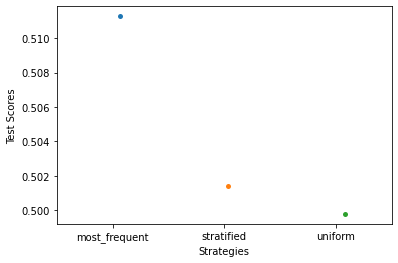

In [23]:
# plot scores against the strategies
ax = sns.stripplot(x=strategies, y=test_scores)
ax.set_xlabel('Strategies')
ax.set_ylabel('Test Scores')
plt.show()

## 4.6 Initial Models<a id='4.6_Initial_Models'></a>

### 4.6.1 Logistic Regression Model<a id='4.6.1_Logistic_Regression_Model'></a>

#### 4.6.1.1 Define the pipeline<a id='4.6.1.1_Define_the_pipeline'></a>

In [24]:
pipe = Pipeline([('std', StandardScaler()), ('lr_clf', LogisticRegression())])

#### 4.6.1.2 Fit the pipeline<a id='4.6.1.2_Fit_the_pipeline'></a>

In [25]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr_clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### 4.6.1.3 Access performance on the test set<a id='4.6.1.3_Access_performance_on_the_test_set'></a>

In [26]:
# print accuracy from testing data
y_pred = pipe.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.6002802924131662


Without tuning the hyperparameters of the `logistic Regression`, the accuracy score is `.60` which isn't that worse looking at the fact a small sample of the data was used.

#### 4.6.1.4 Tuning the model with RandomizedSearchCV<a id='4.6.1.3_Tuning_the_model_with_RandomizedSearchCV'></a>

In [29]:
%%time

# scale training and test set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression
lr_clf = LogisticRegression()

# create hyperparamter
#parameter_grid = {'lr_clf__C': [0.01, 0.1, 1, 2, 10, 100], 'lr_clf__penalty': ['l1', 'l2']}

# create hyperparamter
param_grid = {'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# create RandomizedSearchCV with 3-fold cv
cv_grid = RandomizedSearchCV(lr_clf, param_grid, cv=3, verbose=0, n_jobs=-1, 
                             random_state=42)

# fit the model
best_model = cv_grid.fit(X_train_scaled, y_train)

# best hyperparameter values
print('Tuned Logistic Regression Parameters: {}'.format(best_model.best_params_))
print('Tuned Logistic Regression Accuracy: {}'.format(best_model.best_score_))

Tuned Logistic Regression Parameters: {'penalty': 'l1', 'C': 0.1}
Tuned Logistic Regression Accuracy: 0.5980312110703343
CPU times: user 2min 8s, sys: 1.76 s, total: 2min 9s
Wall time: 31min 39s


Best parameters are `C:0.1` and `penalty:l1` with a best score of almost `0.60` just as the untuned model. No significant difference.

In [30]:
# train and fit the model with the best parameters
lr_best = LogisticRegression(C=0.1, penalty='l1')
lr_best.fit(X_train_scaled, y_train)

# predict on the test set
y_pred2 = lr_best.predict(X_test_scaled)

# check accuracy score
print(accuracy_score(y_pred2, y_test))

0.6000404025100059


After applying the best parameters to the model, the accuracy score was unchanged.

### 4.6.2 RandomForest Model<a id='4.6.2_RandomForest_Model'></a>

#### 4.6.2.1 Initial Model<a id='4.6.2.1_Initial Model'></a>

In [32]:
%%time

# instantiate RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)

# fit to the training set
rf_clf.fit(X_train_scaled, y_train)

# predict on the test set
y_pred_rf = rf_clf.predict(X_test_scaled)

# check accuracy score
print(accuracy_score(y_pred_rf, y_test))

0.5968587048470386
CPU times: user 1min 14s, sys: 1.5 s, total: 1min 15s
Wall time: 1min 17s


The initial model of `Random Forest` model performance is a little less than the initial `Logistic Regression` model. Let's try to tune the model to see if performance increases.

#### 4.6.2.1 Tuning the model with RandomizedSearchCV<a id='4.6.2.1_Tuning_the_model_with_RandomizedSearchCV'></a>

In [35]:
%%time 

# create hyperparameter
param_grid = {'n_estimators': [100, 200, 500],
                    'max_depth': [4,5,6,7,8]}

# instantiate randomforestclassifier
rf_clf2 = RandomForestClassifier()

# create Randomizedsearch with 3-fold
rf_cv = RandomizedSearchCV(rf_clf2, param_grid, n_iter=15, cv=3, random_state=42)

# fit to the training set
best_model = rf_cv.fit(X_train_scaled, y_train)

# best hyperparameter values
print('Tuned Random Forest Parameters: {}'.format(best_model.best_params_))
print('Tuned GridSearch Random Forest Accuracy: {}'.format(best_model.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 100, 'max_depth': 8}
Tuned GridSearch Random Forest Accuracy: 0.6008888589609778
CPU times: user 35min 38s, sys: 28.8 s, total: 36min 7s
Wall time: 8h 19min 49s


In [36]:
# train and fit best parameters 
rf_best = RandomForestClassifier(n_estimators=100, max_depth=8)

# fit to the training set
rf_best.fit(X_train_scaled, y_train)

# predict on test set
y_pred_rf2 = rf_best.predict(X_test_scaled)

# check accuracy score
print(accuracy_score(y_pred_rf2, y_test))

0.6028433266416676


After tuning with the best parameters, the accuracy score just marginally increased on the test. There are still quite some number of hyperparameters that can explored to give the best of performance for the model.

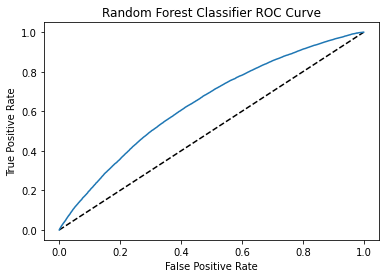

In [41]:
# Calculate the ROC for the model
y_pred_prob = rf_best.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC Curve') 
plt.show();

In [38]:
# Print AUC score
print('AUC: %.3f' % (auc(fpr,tpr)))

AUC: 0.640


In [63]:
rf_importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_best.feature_importances_,3)})

rf_importances = rf_importances.sort_values('importance',ascending=False).set_index('feature')
rf_importances.head(20)

,importance
feature,
AVProductsInstalled,0.169
AVProductStatesIdentifier,0.154
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.052
Census_TotalPhysicalRAM,0.049
Processor_x86,0.037
IsProtected,0.035
Processor_x64,0.034
Census_PrimaryDiskTotalCapacity,0.033
Census_ProcessorModelIdentifier,0.032


### 4.6.3 Xgboost<a id='4.6.3_Xgboost'></a>

#### 4.6.3.1 Initial Model<a id='4.6.3.1_Initial Model'></a>

In [39]:
%%time 
# instantiate the XGBClassifier
xg_boost = XGBClassifier(random_state=42, use_label_encoder=False, n_estimators=150, learning_rate=0.05)

# fit to the train set
xg_model = xg_boost.fit(X_train_scaled, y_train)

# predict on the test set
y_pred_xg = xg_model.predict(X_test_scaled)

# check for accuracy
print(accuracy_score(y_pred_xg, y_test))

0.607237099604813
CPU times: user 3min 31s, sys: 1.62 s, total: 3min 33s
Wall time: 3min 37s


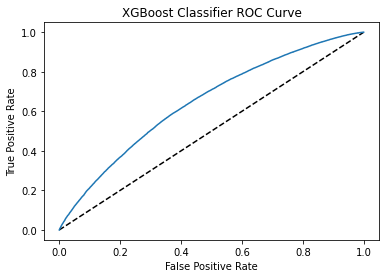

In [42]:
# Calculate the ROC for the model
y_pred_xg_proba = xg_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xg_proba) 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost Classifier') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Classifier ROC Curve') 
plt.show();

In [43]:
# Print AUC score
print('AUC: %.3f' % (auc(fpr,tpr)))

AUC: 0.647


#### 4.6.3.2 Tuning the model with RandomizedSearchCV<a id='4.6.3.2_Tuning_the_model_with_RandomizedSearchCV'></a>

In [44]:
%%time 

from scipy import stats
from sklearn.model_selection import KFold

xg_boost2 = XGBClassifier(objective = 'binary:logistic')

param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 3
kfold_3 = KFold(shuffle = True, n_splits = numFolds)

xg_cv = RandomizedSearchCV(xg_boost2, 
                         param_distributions = param_dist,
                         cv = kfold_3,  
                         n_iter = 10, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1
                                    )

best_model = xg_cv.fit(X_train_scaled, y_train)

# best hyperparameter values
print('Tuned XGBoost Parameters: {}'.format(best_model.best_params_))
print('Tuned XGBoost Accuracy: {}'.format(best_model.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 103.1min finished


Tuned XGBoost Parameters: {'colsample_bytree': 0.7469719150966905, 'learning_rate': 0.47636943969494344, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 171, 'subsample': 0.9172285144008501}
Tuned XGBoost Accuracy: 0.6198499699379794
CPU times: user 7min 9s, sys: 1.59 s, total: 7min 10s
Wall time: 2h 5s


In [46]:
# train and fit the best parameters
xg_best = XGBClassifier(objective = 'binary:logistic', colsample_bytree=0.75, learning_rate=0.48, max_depth=9, min_child_weight=2,
                          n_estimators=171, subsample=0.92)

# fit to the training set
xg_best.fit(X_train_scaled, y_train)

# predict on the test set
y_pred_xg2 = xg_best.predict(X_test_scaled)

# check for accuracy
print(accuracy_score(y_pred_xg2, y_test))

0.5968208274939081


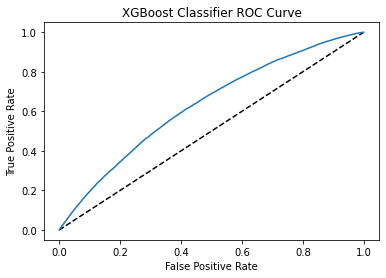

In [47]:
# Calculate the ROC for the model
y_pred_xg2_proba = xg_best.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xg2_proba) 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost Classifier') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Classifier ROC Curve') 
plt.show();

In [48]:
# Print AUC score
print('AUC: %.3f' % (auc(fpr,tpr)))

AUC: 0.631


#### 4.6.3.3 Feature Importance<a id='4.6.3.3_Feature_Importance'></a>

In [60]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(xg_best.feature_importances_,3)})

importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(20)

,importance
feature,
AVProductsInstalled,0.074
IsProtected,0.035
Census_IsVirtualDevice,0.029
RtpStateBitfield,0.026
SkuEdition_Enterprise LTSB,0.025
Census_TotalPhysicalRAM,0.023
Census_GenuineStateName_UNKNOWN,0.021
Processor_x64,0.020
Census_IsAlwaysOnAlwaysConnectedCapable,0.018


<AxesSubplot:xlabel='feature'>

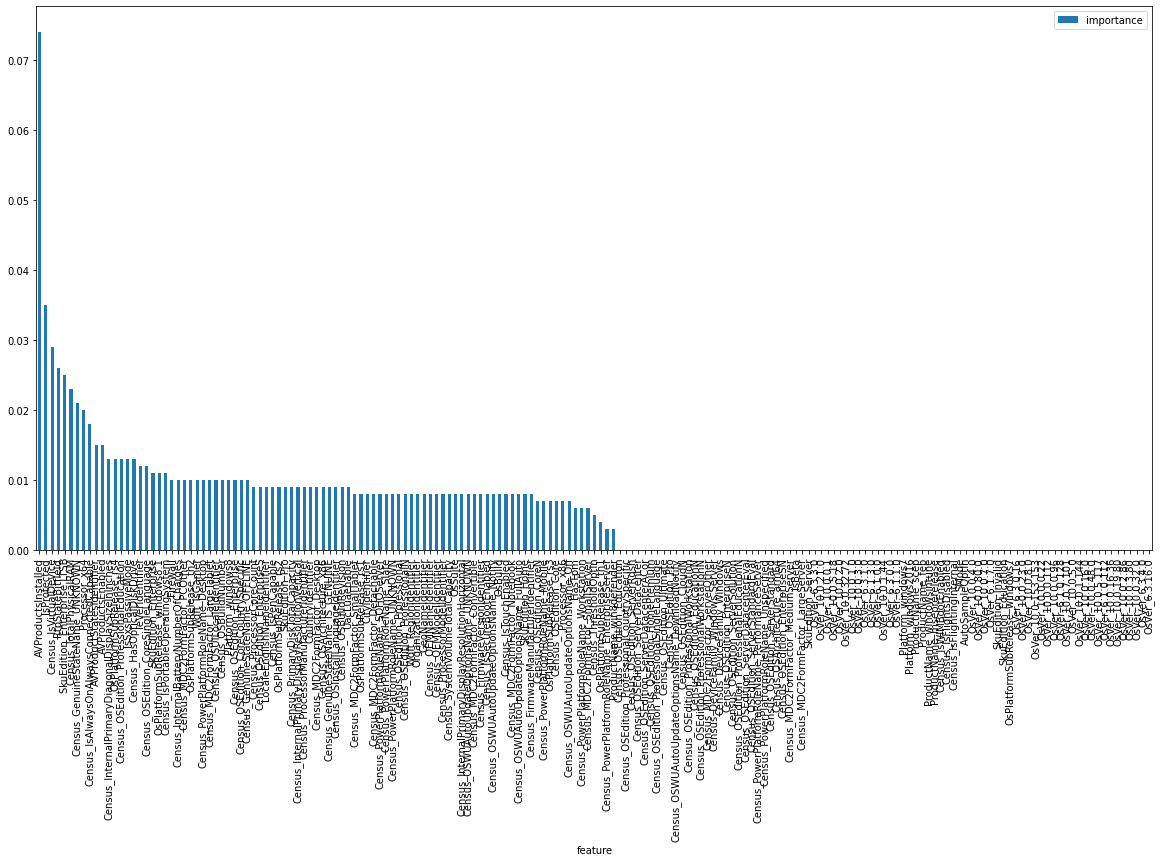

In [62]:
importances.plot(kind='bar',figsize=(20,10))

`XG Boost Classifier` didn't perform badly on both the train set and test set. There was little or no difference in terms of performance compared to the `Random Forest Classifier`. Due to memory and time, we only performed 3-fold cross validation during tuning and also only a few hyperparameters were explored. Later we could explore hyperparameters for better performance and the same time avoiding overfitting the model.

The dominant top 5 features are:
* AVProductsInstalled
* IsProtected
* Census_IsVirtualDevice
* RtpStateBitfield
* SkuEdition_Enterprise LTSB

and some of these are also common in the top 10 feature importance in the `Random Forest` model.

## 4.7 Final Model Selection<a id='4.7_Final_Model_Selection'></a>

`XGBoost` classifier had a better accuracy score during training and also was marginally less than `Random Forest` model on the test test. In the future we would like to also test the performance of these models on the full dataset. There are other algorithms we could also explore like the `LightGBM` classifier which is know for faster training speed and high efficiency and capable of large data like this example.

## 4.13 Save best model<a id='4.13_Save_best_model'></a>

In [66]:
#Let's call this model version '1.0'
chosen_model = xg_cv.best_estimator_
chosen_model.version = 1.0
chosen_model.pandas_version = pd.__version__
chosen_model.numpy_version = np.__version__
chosen_model.sklearn_version = sklearn_version
chosen_model.X_columns = [col for col in X_train.columns]
chosen_model.build_datetime = datetime.datetime.now()

In [67]:
# save the model
modelpath = '/Users/felixoffei/Desktop/Springboard/Capstone/'
save_file(chosen_model, 'malware_prediction_model.pkl', modelpath)

Writing file.  "/Users/felixoffei/Desktop/Springboard/Capstone/malware_prediction_model.pkl"
